In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



In [ ]:

class ManualImageDataGenerator:
    def __init__(self, preprocessing_function=None, horizontal_flip=False, rotation_range=0, 
                 zoom_range=0, width_shift_range=0, height_shift_range=0):
        self.preprocessing_function = preprocessing_function
        self.horizontal_flip = horizontal_flip
        self.rotation_range = rotation_range
        self.zoom_range = zoom_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
    
    def flow_from_directory(self, directory, target_size, batch_size=32, class_mode='categorical', shuffle=True):
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        
        self.classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(directory, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_indices[class_name])
        
        self.n_samples = len(self.image_paths)
        self.indices = np.arange(self.n_samples)
        
        if self.shuffle:
            np.random.shuffle(self.indices)
            
        self.current_index = 0
        return self
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_index >= self.n_samples:
            self.current_index = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
            raise StopIteration
        
        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_images = []
        batch_labels = []
        
        for idx in batch_indices:
            img = Image.open(self.image_paths[idx])
            img = img.resize(self.target_size)
            img_array = np.array(img)
            
            if len(img_array.shape) == 2:
                img_array = np.stack([img_array] * 3, axis=-1)
            
            img_array = self.apply_augmentation(img_array)
            
            if self.preprocessing_function:
                img_array = self.preprocessing_function(img_array)
            
            batch_images.append(img_array)
            batch_labels.append(self.labels[idx])
        
        self.current_index += len(batch_indices)
        
        if self.class_mode == 'categorical':
            batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.classes))
        
        return np.array(batch_images), np.array(batch_labels)
    
    def apply_augmentation(self, img_array):
        img = img_array.copy()
        
        if self.horizontal_flip and random.random() > 0.5:
            img = np.fliplr(img)
        
        if self.rotation_range > 0:
            angle = random.uniform(-self.rotation_range, self.rotation_range)
            img = self.rotate_image(img, angle)
        
        if self.zoom_range > 0:
            zoom = random.uniform(1 - self.zoom_range, 1 + self.zoom_range)
            img = self.zoom_image(img, zoom)
        
        if self.width_shift_range > 0:
            shift_x = random.uniform(-self.width_shift_range, self.width_shift_range) * img.shape[1]
            img = self.shift_image(img, shift_x, 0)
        
        if self.height_shift_range > 0:
            shift_y = random.uniform(-self.height_shift_range, self.height_shift_range) * img.shape[0]
            img = self.shift_image(img, 0, shift_y)
        
        return img
    
    def rotate_image(self, image, angle):
        height, width = image.shape[:2]
        center = (width // 2, height // 2)
        
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (width, height))
        return rotated
    
    def zoom_image(self, image, zoom_factor):
        height, width = image.shape[:2]
        
        new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
        
        start_x = (width - new_width) // 2
        start_y = (height - new_height) // 2
        
        zoomed = cv2.resize(image, (new_width, new_height))
        
        if zoom_factor > 1:
            result = zoomed[start_y:start_y + height, start_x:start_x + width]
        else:
            result = np.zeros_like(image)
            y_start = (height - new_height) // 2
            x_start = (width - new_width) // 2
            result[y_start:y_start + new_height, x_start:x_start + new_width] = zoomed
        
        return result
    
    def shift_image(self, image, shift_x, shift_y):
        height, width = image.shape[:2]
        translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        shifted = cv2.warpAffine(image, translation_matrix, (width, height))
        return shifted

def efficientnet_preprocess_input(x):
    x = x.astype('float32')
    x /= 255.0
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    x[..., 0] /= std[0]
    x[..., 1] /= std[1]
    x[..., 2] /= std[2]
    return x

base_dir = "C:\Users\nacha\Downloads\archive (2)\marine-animals-dataset\versions\1"
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ManualImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2
)

valid_datagen = ManualImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input
)

test_datagen = ManualImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
print("Class indices:", class_indices)

Found 1241 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Class indices: {'Dolphin': 0, 'Fish': 1, 'Lobster': 2, 'Octopus': 3, 'Sea Horse': 4}


In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))


base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce spatial dimensions
x = Dropout(0.5)(x)              # Regularization to avoid overfitting
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Regularization
output = Dense(5, activation='softmax')(x)  # Final output layer for 5 classes


model = Model(inputs=base_model.input, outputs=output)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


71686520/71686520 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 380, 380, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 380, 380, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

                                )                                 'block1a_project_bn[0][0]']     
                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 190, 190, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 190, 190, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 190, 190, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
          

                                                                                                  
 block2c_expand_activation (Act  (None, 95, 95, 192)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 95, 95, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 95, 95, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_a

 g2D)                                                            ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 48, 48, 192)  4800       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 48, 48, 192)  768        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 48, 48, 192)  0          ['block3a_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 336)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block3c_se_reduce[0][0]']      
                                                                                                  
 block3c_s

 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 24, 24, 336)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
          

                                                                                                  
 block4c_project_conv (Conv2D)  (None, 24, 24, 112)  75264       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 24, 24, 112)  448        ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 24, 24, 112)  0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 24, 24, 112)  0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
          

                                                                                                  
 block4e_drop (Dropout)         (None, 24, 24, 112)  0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 24, 24, 112)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, 24, 24, 672)  75264       ['block4e_add[0][0]']            
                                                                                                  
 block4f_expand_bn (BatchNormal  (None, 24, 24, 672)  2688       ['block4f_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5b_expand_activation (Act  (None, 24, 24, 960)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 24, 24, 960)  24000      ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 24, 24, 960)  3840       ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_a

 D)                                                              ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, 24, 24, 960)  3840       ['block5d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 24, 24, 960)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 960)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5f_activation (Activation  (None, 24, 24, 960)  0          ['block5f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 960)         0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_s

 block6b_se_reshape (Reshape)   (None, 1, 1, 1632)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 12, 12, 1632  0           ['block6b_activation[0][0]',     
                                )                                 'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 12, 12, 272)  443904      ['block6b_se_excite[0][0]']      
          

                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 12, 12, 1632  0           ['block6d_activation[0][0]',     
                                )                                 'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 12, 12, 272)  443904      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 12, 12, 272)  1088       ['block6d_project_conv[0][0]']   
 lization)                                                                                        
          

 block6f_se_excite (Multiply)   (None, 12, 12, 1632  0           ['block6f_activation[0][0]',     
                                )                                 'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 12, 12, 272)  443904      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 12, 12, 272)  1088       ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 12, 12, 272)  0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_a

 block6h_project_conv (Conv2D)  (None, 12, 12, 272)  443904      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 12, 12, 272)  1088       ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_drop (Dropout)         (None, 12, 12, 272)  0           ['block6h_project_bn[0][0]']     
                                                                                                  
 block6h_add (Add)              (None, 12, 12, 272)  0           ['block6h_drop[0][0]',           
                                                                  'block6g_add[0][0]']            
                                                                                                  
 block7a_e

                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 top_conv (Conv2D)              (None, 12, 12, 1792  802816      ['block7b_add[0][0]']            
                                )                                                                 
                                                                                                  
 top_bn (BatchNormalization)    (None, 12, 12, 1792  7168        ['top_conv[0][0]']               
                                )                                                                 
                                                                                                  
 top_activation (Activation)    (None, 12, 12, 1792  0           ['top_bn[0][0]']                 
                                )                                                                 
          

In [ ]:

history = model.fit(
    train_generator,
    epochs=10,                  
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    verbose=1
)


val_loss, val_accuracy = model.evaluate(valid_generator, verbose=1)
print(f"Validation Accuracy after initial training: {val_accuracy * 100:.2f}%")


Epoch 1/10
39/39 [==============================] - 54s 970ms/step - loss: 0.5061 - accuracy: 0.8066 - val_loss: 0.4756 - val_accuracy: 0.8600
Epoch 2/10
39/39 [==============================] - 32s 816ms/step - loss: 0.2446 - accuracy: 0.9001 - val_loss: 0.4458 - val_accuracy: 0.8480
Epoch 3/10
39/39 [==============================] - 32s 826ms/step - loss: 0.2137 - accuracy: 0.9226 - val_loss: 0.4598 - val_accuracy: 0.8600
Epoch 4/10
39/39 [==============================] - 33s 827ms/step - loss: 0.1780 - accuracy: 0.9347 - val_loss: 0.5296 - val_accuracy: 0.8480
Epoch 5/10
39/39 [==============================] - 34s 857ms/step - loss: 0.1741 - accuracy: 0.9355 - val_loss: 0.4472 - val_accuracy: 0.8760
Epoch 6/10
39/39 [==============================] - 38s 980ms/step - loss: 0.1437 - accuracy: 0.9476 - val_loss: 0.4897 - val_accuracy: 0.8520
Epoch 7/10
39/39 [==============================] - 36s 920ms/step - loss: 0.1667 - accuracy: 0.9331 - val_loss: 0.4911 - val_accuracy: 0.8640

In [ ]:

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 2s 534ms/step - loss: 0.2509 - accuracy: 0.8900
Test Accuracy: 89.00%


In [ ]:
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

history_finetune = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    callbacks=callbacks,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy after fine-tuning: {test_accuracy * 100:.2f}%")

Epoch 1/20
39/39 [==============================] - 44s 887ms/step - loss: 0.1582 - accuracy: 0.9492 - val_loss: 0.4653 - val_accuracy: 0.8720 - lr: 1.0000e-04
Epoch 2/20
39/39 [==============================] - 32s 825ms/step - loss: 0.1050 - accuracy: 0.9654 - val_loss: 0.4610 - val_accuracy: 0.8840 - lr: 1.0000e-04
Epoch 3/20
39/39 [==============================] - 33s 836ms/step - loss: 0.0766 - accuracy: 0.9718 - val_loss: 0.4581 - val_accuracy: 0.8880 - lr: 1.0000e-04
Epoch 4/20
39/39 [==============================] - 34s 857ms/step - loss: 0.0643 - accuracy: 0.9782 - val_loss: 0.4486 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 5/20
39/39 [==============================] - 33s 843ms/step - loss: 0.0648 - accuracy: 0.9774 - val_loss: 0.4382 - val_accuracy: 0.8760 - lr: 1.0000e-04
Epoch 6/20
39/39 [==============================] - 35s 882ms/step - loss: 0.0601 - accuracy: 0.9823 - val_loss: 0.4332 - val_accuracy: 0.8840 - lr: 1.0000e-04
Epoch 7/20
39/39 [======================

In [ ]:

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 1s 223ms/step - loss: 0.2289 - accuracy: 0.9200
Test Accuracy: 92.00%


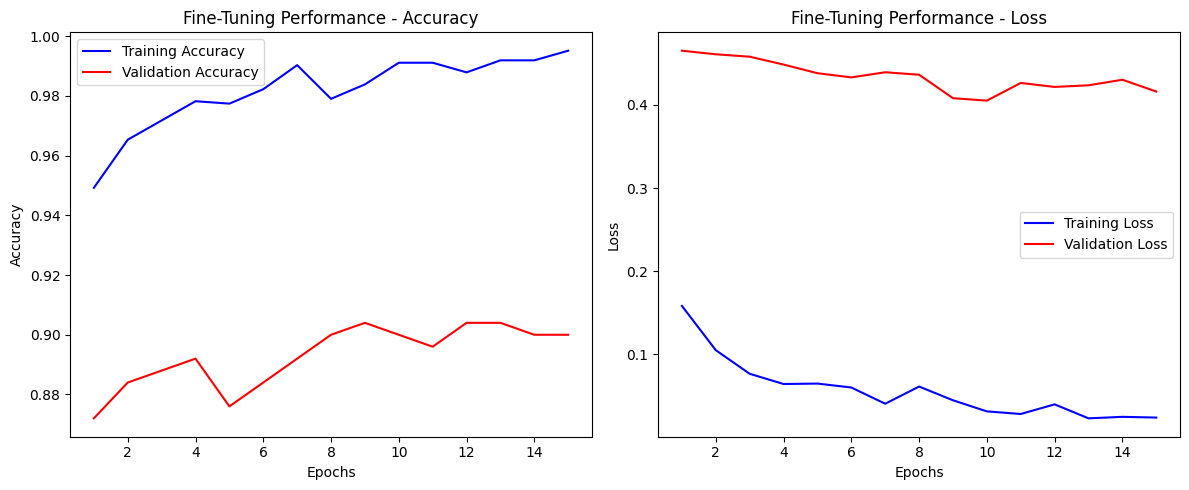

In [ ]:



def plot_training(history, title="Model Performance"):
    # Retrieve metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training(history_finetune, title="Fine-Tuning Performance")


4/4 [==============================] - 4s 307ms/step


<Figure size 800x600 with 0 Axes>

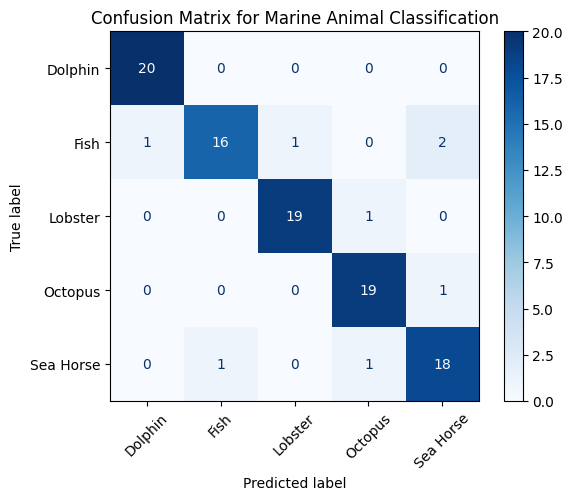

In [ ]:


test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Marine Animal Classification")
plt.xticks(rotation=45)
plt.show()